In [1]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

C:\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
import random

n = 80000 #number of records in file
s = 50000 #desired sample size
skip = sorted(random.sample(range(n),n-s))

df_mitbih_train = pd.read_csv("C:\\Users\\a_rad\\Downloads\\mitbih_train.csv", header=None, skiprows=skip)
df_mitbih_test = pd.read_csv("C:\\Users\\a_rad\\Downloads\\mitbih_test.csv", header=None, skiprows=skip)

In [3]:
df_mitbih_test.rename(columns={187: 'class'}, inplace=True)
df_mitbih_train.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",     #0: "Нормальный"
    1: "Artial Premature", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Premature ventricular contraction", # "Преждевременное сокращение желудочков"
    3: "Fusion of ventricular and normal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Fusion of paced and normal" #"Cлияние стимулированного и нормального ритма"
}

df_mitbih_test['label'] = df_mitbih_test.iloc[:, -1].map(id_to_label)
df_mitbih_train['label'] = df_mitbih_train.iloc[:, -1].map(id_to_label)

In [4]:
id_to_label = {
    0: "Normal",     #0: "условно-здоровый"
    1: "Abnormal", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Abnormal", # "Преждевременное сокращение желудочков"
    3: "Abnormal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Abnormal" #"Cлияние стимулированного и нормального ритма"
}

df_mitbih_test['healthy_status'] = df_mitbih_test.iloc[:, -2].map(id_to_label)
df_mitbih_train['healthy_status'] = df_mitbih_train.iloc[:, -2].map(id_to_label)

In [5]:
print(df_mitbih_train['class'].value_counts(), end="\n-------------------\n")
print(df_mitbih_train['healthy_status'].value_counts())

class
0.0    45324
4.0     6431
2.0     3791
1.0     1367
3.0      641
Name: count, dtype: int64
-------------------
healthy_status
Normal      45324
Abnormal    12230
Name: count, dtype: int64


In [6]:
from sklearn.utils import shuffle
df_mitbih_test = shuffle(df_mitbih_test)
df_mitbih_train = shuffle(df_mitbih_train)

df_mitbih_test = df_mitbih_test.reset_index(drop='True')
df_mitbih_train = df_mitbih_train.reset_index(drop='True')

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Создание экземпляра RandomUnderSampler
# rus_method = RandomUnderSampler(random_state=42, sampling_strategy="majority")
rus_method = RandomUnderSampler(random_state=42)

df = df_mitbih_train

# Применение уменьшения выборки к данным
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df, df['class'])

new_df =pd.concat([X_resampled, y_resampled])

new_df = new_df.dropna()
new_df['class'].value_counts()

class
0.0    641
1.0    641
2.0    641
3.0    641
4.0    641
Name: count, dtype: int64

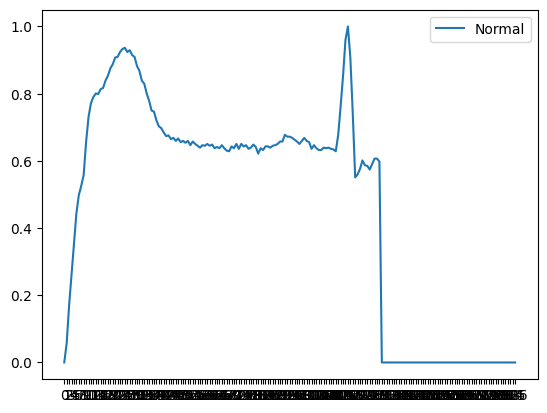

In [8]:
# пример как выглядит кардиограмма из датасета
plt.plot(df_mitbih_train.iloc[5][:-3], label=str(df_mitbih_train.iloc[0]['label']))
plt.legend()
plt.show()

## Класс для загрузки датасета

In [9]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-3].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [10]:
def get_dataloader(df, phase: str, batch_size: int = 96):
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=123, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader

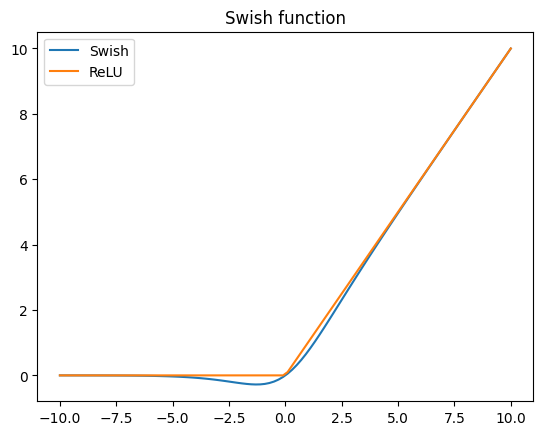

In [11]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

## Модель для обучения

In [12]:
class RNN(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p = 0.2,
        bidirectional = False,
    ):
        super().__init__()

        self.rnn_layer = nn.LSTM(
            input_size=input_size,
            hidden_size=hid_size,
            num_layers=num_rnn_layers,
            dropout=dropout_p if num_rnn_layers>1 else 0,
            bidirectional=bidirectional,
            batch_first=True,
        )

    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [13]:
class ConvNormPool(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [14]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [15]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion


In [16]:
class Trainer:
    def __init__(self, df, net, lr, batch_size, num_epochs):
        #self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        #self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.optimizer = AdamW(net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(df, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase, net):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        #self.net.train() if phase == 'train' else self.net.eval()
        net.train() if phase == 'train' else net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(device)
            target = target.to(device)
            #data = data.to(config.device)
            #target = target.to(config.device)

            #output = self.net(data)
            output = net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())

        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self, net):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        net.to(device)  # Перемещаем модель на устройство
        
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train',net=net)
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val',net=net)
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                #torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
                torch.save(net.state_dict(), f"best_model_epoc{epoch}.pth")
            #clear_output()

In [29]:
model = RNNAttentionModel(1, 96, bidirectional=False)

train mode | time: 17:55:22
loss: 1.3399418564069838, accuracy: 0.6088376322751323, f1: 0.5564749808842768, precision: 0.6143182108037261, recall: 0.6861220965550446


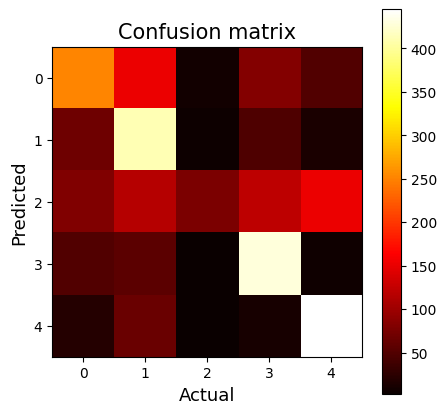

val mode | time: 17:55:25
loss: 1.6626990182059151, accuracy: 0.5844832251082251, f1: 0.5109309627867856, precision: 0.5807360426688158, recall: 0.6989733494269954


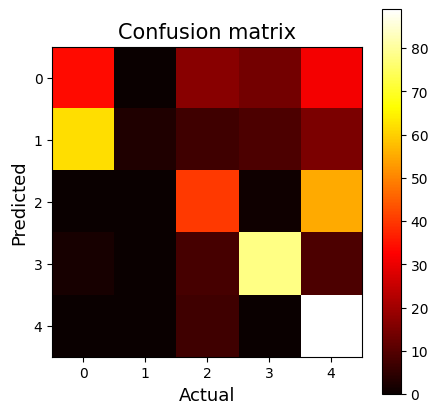


New checkpoint

train mode | time: 17:55:26
loss: 1.1514051244372414, accuracy: 0.7983217592592592, f1: 0.7882502570877564, precision: 0.8019872237121242, recall: 0.8057977490059532


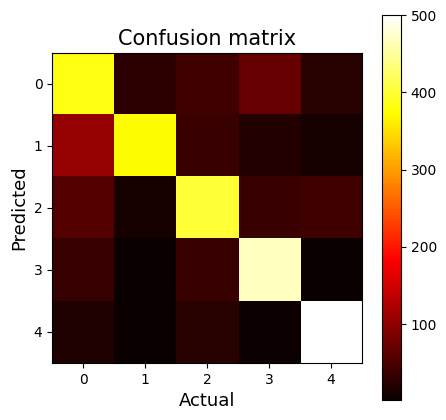

val mode | time: 17:55:29
loss: 1.3016729354858398, accuracy: 0.8806818181818182, f1: 0.8642368949122886, precision: 0.8724736125587519, recall: 0.9045286223923995


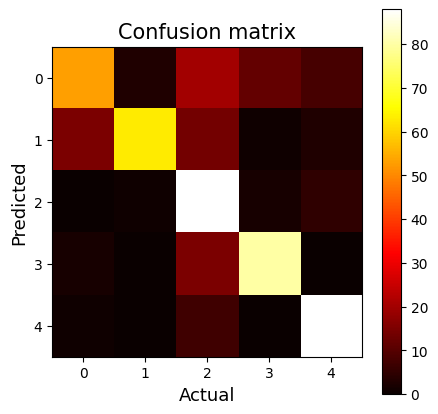


New checkpoint

train mode | time: 17:55:30
loss: 1.1187436027186257, accuracy: 0.8312665343915343, f1: 0.8238078399750128, precision: 0.8358611862730615, recall: 0.8368847292648708


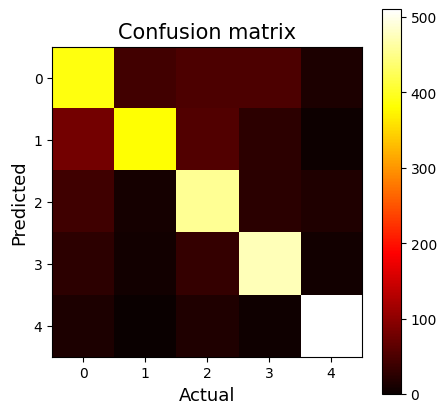

val mode | time: 17:55:33
loss: 1.2316406113760812, accuracy: 0.9429112554112554, f1: 0.9296605850319396, precision: 0.9333125722378265, recall: 0.9469648395488731


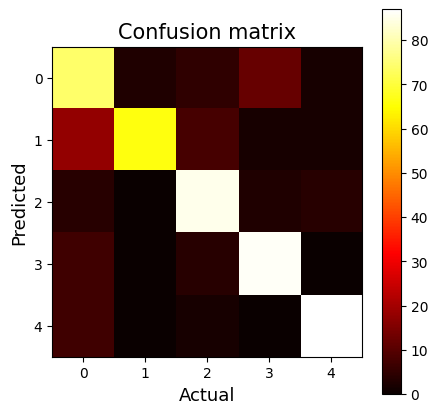


New checkpoint

train mode | time: 17:55:33
loss: 1.0907269843987055, accuracy: 0.859250992063492, f1: 0.8531484834783962, precision: 0.8621212935343853, recall: 0.8641847685379308


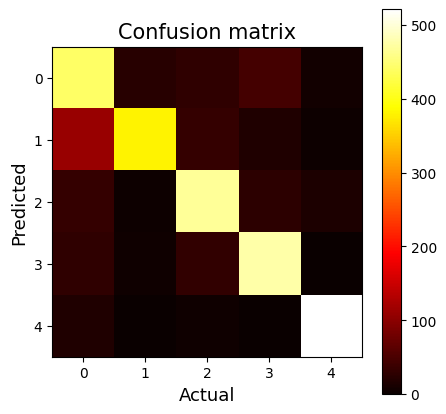

val mode | time: 17:55:36
loss: 1.2248470612934657, accuracy: 0.9475108225108225, f1: 0.9351350016161962, precision: 0.9384954962232716, recall: 0.9510557267932321


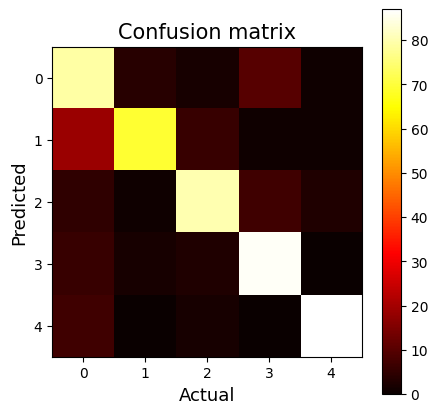

train mode | time: 17:55:37
loss: 1.0799584757714045, accuracy: 0.8663194444444444, f1: 0.859087724830758, precision: 0.8670528444273468, recall: 0.8704143035368157


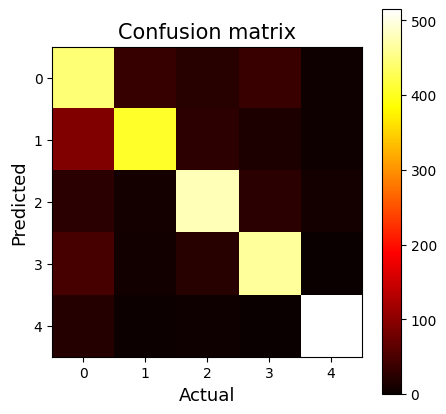

val mode | time: 17:55:40
loss: 1.2322140421186174, accuracy: 0.9406791125541126, f1: 0.9307397269512877, precision: 0.9330192031419363, recall: 0.950415291622722


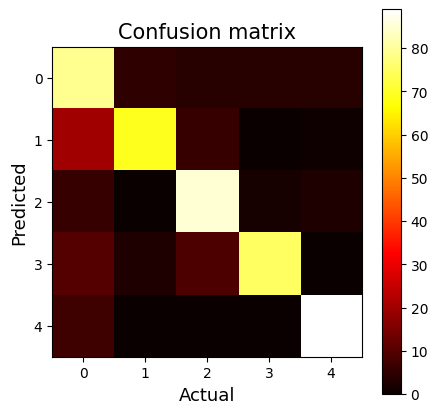


New checkpoint

train mode | time: 17:55:41
loss: 1.0616358915964763, accuracy: 0.8889302248677249, f1: 0.8837645816047531, precision: 0.8907251518363857, recall: 0.8930620535692116


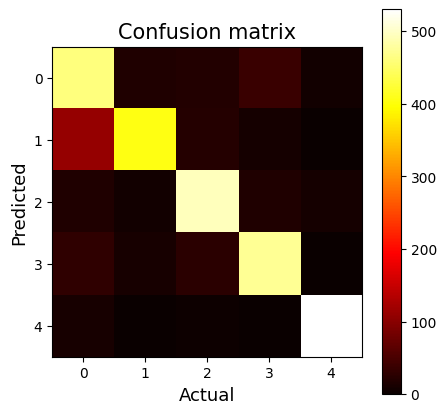

val mode | time: 17:55:44
loss: 1.2104615824563163, accuracy: 0.9650974025974026, f1: 0.9524923599325358, precision: 0.9568139005080623, recall: 0.9691111526195559


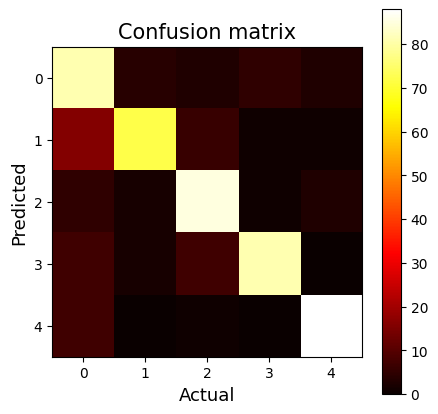

train mode | time: 17:55:45
loss: 1.05158373997325, accuracy: 0.898520171957672, f1: 0.8954993078744733, precision: 0.9017196702629032, recall: 0.9039501150233126


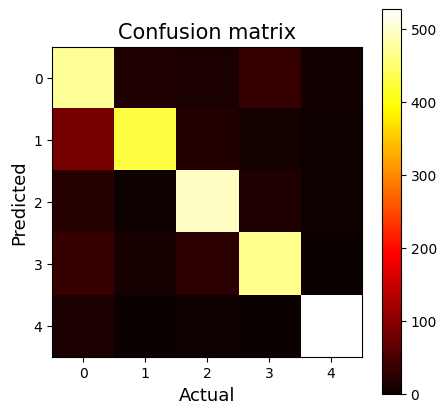

val mode | time: 17:55:48
loss: 1.2120624610355921, accuracy: 0.9609036796536797, f1: 0.950221439010319, precision: 0.9538636982212834, recall: 0.9605878738441763


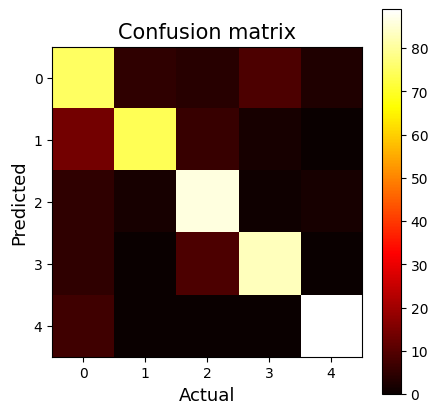

train mode | time: 17:55:49
loss: 1.046055366595586, accuracy: 0.9051339285714286, f1: 0.9021724463954506, precision: 0.908506801199194, recall: 0.9103036796160414


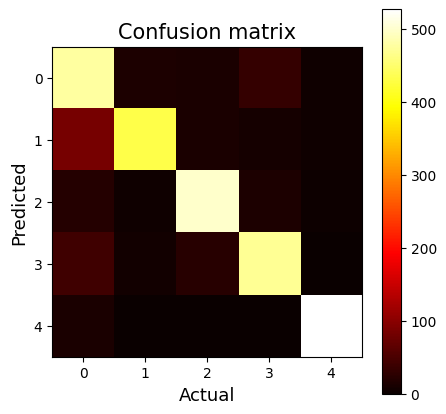

val mode | time: 17:55:52
loss: 1.2025804434503828, accuracy: 0.9628652597402597, f1: 0.9528389502153581, precision: 0.9544145129527702, recall: 0.9714864030509761


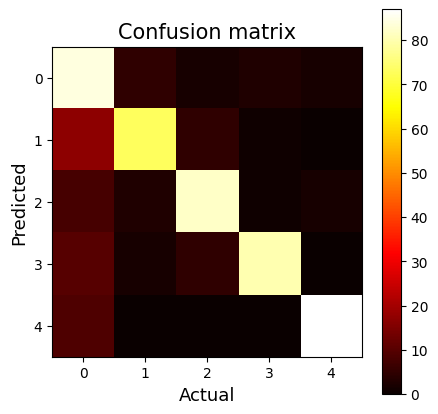


New checkpoint

train mode | time: 17:55:53
loss: 1.0314599559420632, accuracy: 0.9171213624338624, f1: 0.9133342722294204, precision: 0.9180128995736028, recall: 0.9200821404667049


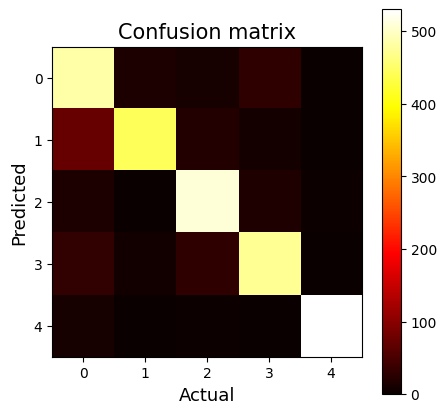

val mode | time: 17:55:56
loss: 1.1880875996180944, accuracy: 0.9895156926406926, f1: 0.981918470826283, precision: 0.9847571844343184, recall: 0.9917886571878168


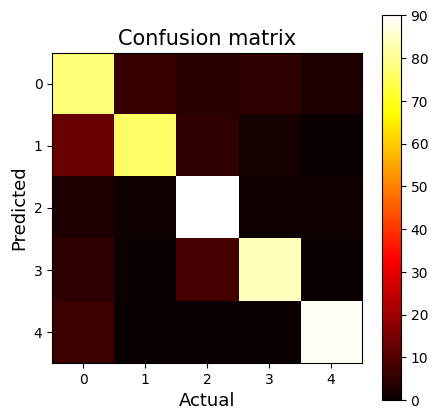


New checkpoint

train mode | time: 17:55:56
loss: 1.024328847726186, accuracy: 0.9267939814814815, f1: 0.9238616027097761, precision: 0.9291363496283884, recall: 0.9281442173255625


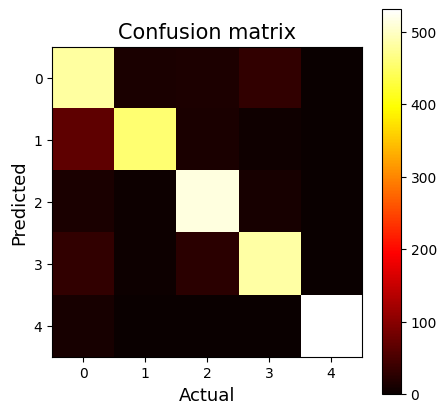

val mode | time: 17:56:00
loss: 1.1801722390311105, accuracy: 0.9962121212121212, f1: 0.9896632142277041, precision: 0.9908231789832851, recall: 0.9999473962079003


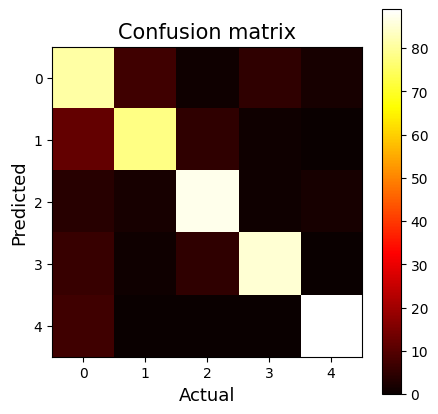


New checkpoint

train mode | time: 17:56:00
loss: 1.0224104183060783, accuracy: 0.9264219576719577, f1: 0.9224215817819514, precision: 0.9280490455291428, recall: 0.9266683956675882


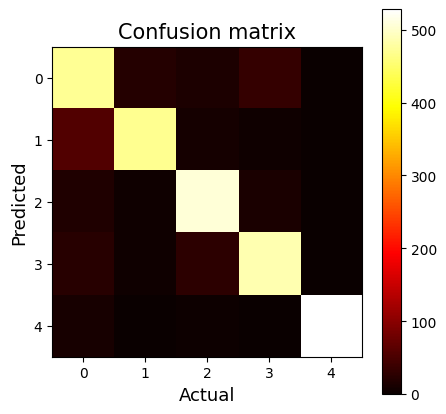

val mode | time: 17:56:03
loss: 1.1968110799789429, accuracy: 0.9783549783549784, f1: 0.9690778448056943, precision: 0.9704358445623372, recall: 0.9839849902665029


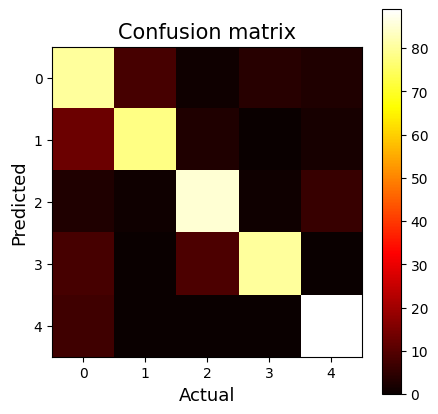

train mode | time: 17:56:04
loss: 1.0156613091627757, accuracy: 0.9375, f1: 0.9348365787727888, precision: 0.9409284183349865, recall: 0.9372202189948042


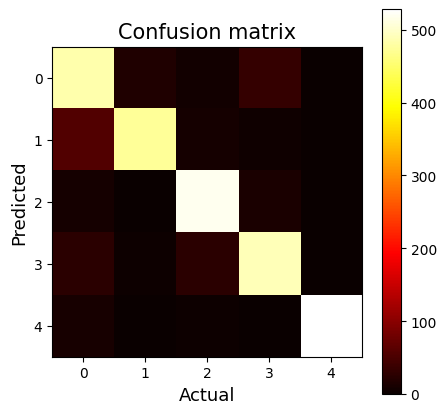

val mode | time: 17:56:07
loss: 1.1858891929898943, accuracy: 0.9872835497835498, f1: 0.9808469597750703, precision: 0.9835763268624833, recall: 0.9872384711460341


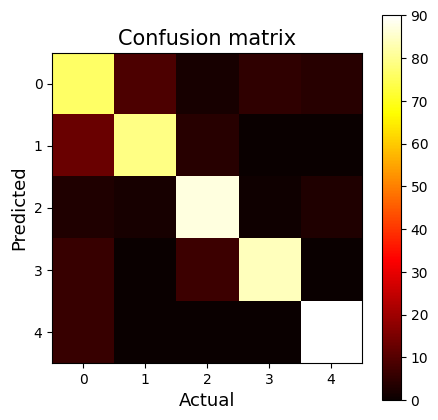

train mode | time: 17:56:08
loss: 1.0114342598688035, accuracy: 0.9393601190476191, f1: 0.9374442421721948, precision: 0.9425355572032927, recall: 0.941091126516198


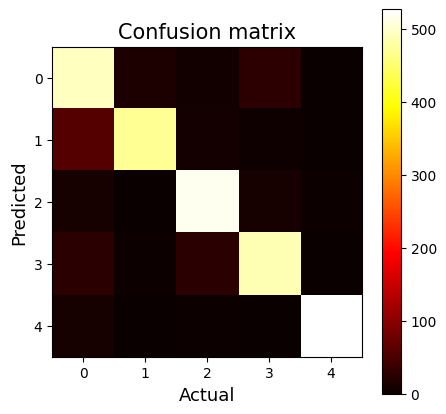

val mode | time: 17:56:11
loss: 1.1742147547858102, accuracy: 1.0050054112554112, f1: 0.9999447609345605, precision: 1.0026410553179683, recall: 1.0088294455311262


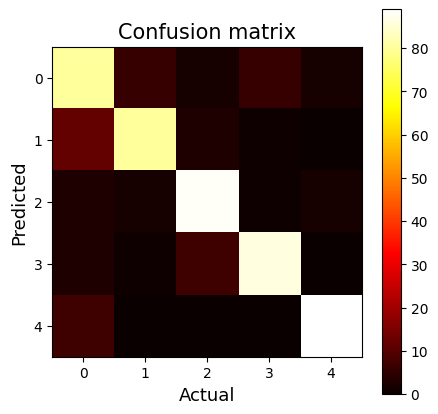


New checkpoint

train mode | time: 17:56:12
loss: 1.0079673713161832, accuracy: 0.9430803571428571, f1: 0.9402309206977529, precision: 0.9453831373673257, recall: 0.9421428564882788


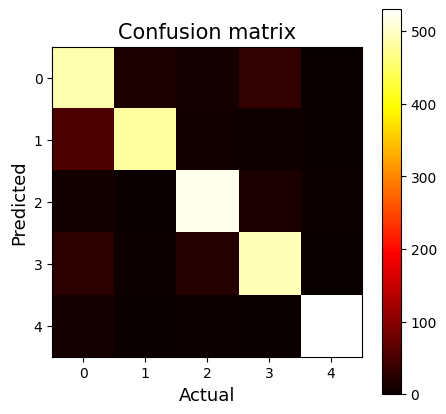

val mode | time: 17:56:15
loss: 1.1790993128504073, accuracy: 1.0029085497835497, f1: 0.9978754912977339, precision: 0.9984865473609393, recall: 1.0079488322135381


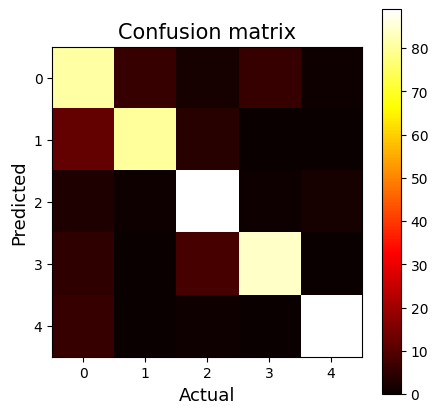

train mode | time: 17:56:16
loss: 1.0027830799420674, accuracy: 0.9490327380952381, f1: 0.9469448595166903, precision: 0.9510182133623091, recall: 0.9501807718005579


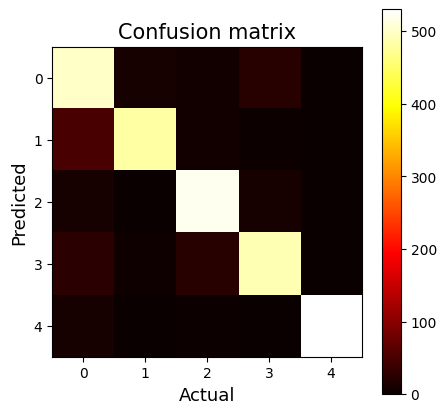

val mode | time: 17:56:19
loss: 1.1724461572510856, accuracy: 1.00487012987013, f1: 1.0022981960529516, precision: 1.0042038342757054, recall: 1.0115957315327064


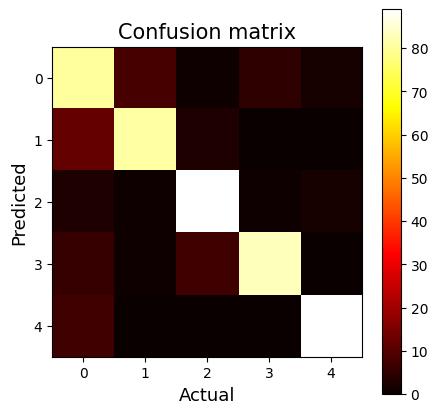


New checkpoint

train mode | time: 17:56:20
loss: 0.9998042909871965, accuracy: 0.9508928571428571, f1: 0.9489059242517748, precision: 0.9533950188876107, recall: 0.9508710003927106


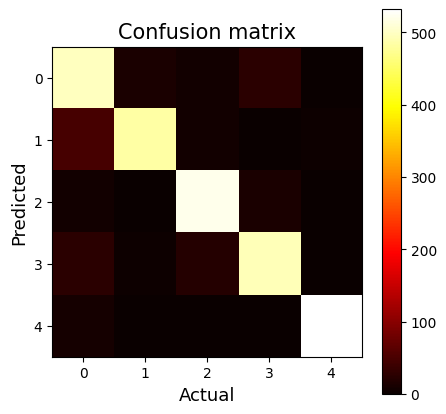

val mode | time: 17:56:23
loss: 1.1731990660939897, accuracy: 1.0071022727272727, f1: 1.0046921905577455, precision: 1.0068012368731079, recall: 1.0137795444518134


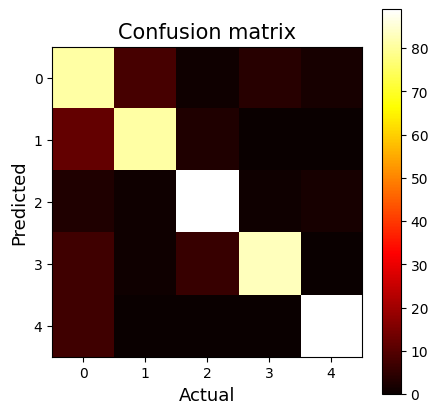


New checkpoint

train mode | time: 17:56:24
loss: 0.9975784648032415, accuracy: 0.953125, f1: 0.9513774066031454, precision: 0.9553882869550715, recall: 0.9537691689307941


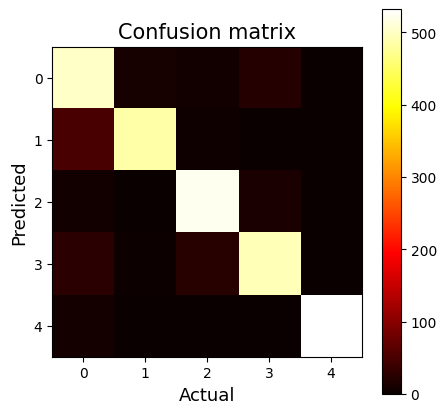

val mode | time: 17:56:28
loss: 1.1727284789085388, accuracy: 1.00487012987013, f1: 1.0020635438421421, precision: 1.0044202844921553, recall: 1.0108791115513804


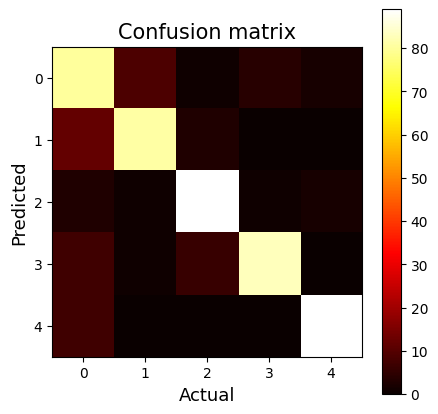


New checkpoint

train mode | time: 17:56:29
loss: 0.996618960584913, accuracy: 0.9538690476190477, f1: 0.9519993272251481, precision: 0.9559702975370821, recall: 0.9543682873660471


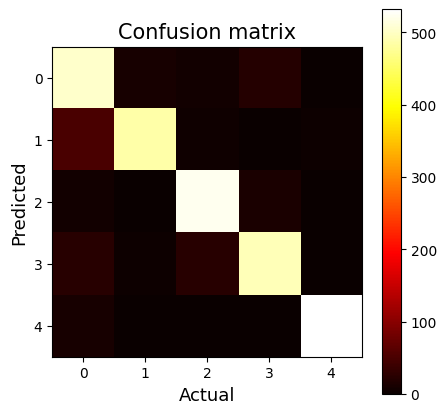

val mode | time: 17:56:33
loss: 1.1730952262878418, accuracy: 1.00487012987013, f1: 1.0020635438421421, precision: 1.0044202844921553, recall: 1.0108791115513804


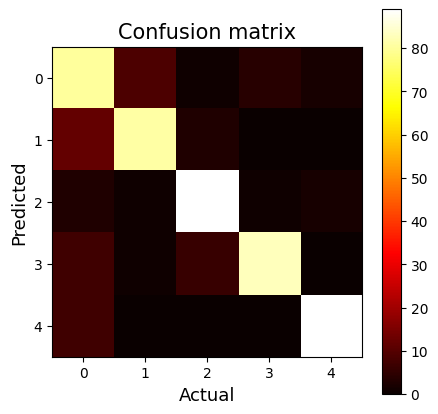


New checkpoint

train mode | time: 17:56:34
loss: 0.9958535972095671, accuracy: 0.9546130952380952, f1: 0.9529982640067787, precision: 0.956917912300486, recall: 0.9555891743222281


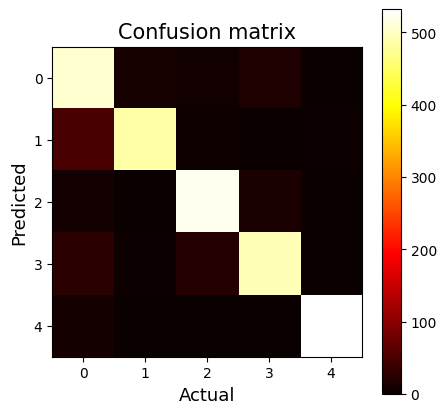

val mode | time: 17:56:38
loss: 1.1728536827223641, accuracy: 1.00487012987013, f1: 1.0020635438421421, precision: 1.0044202844921553, recall: 1.0108791115513804


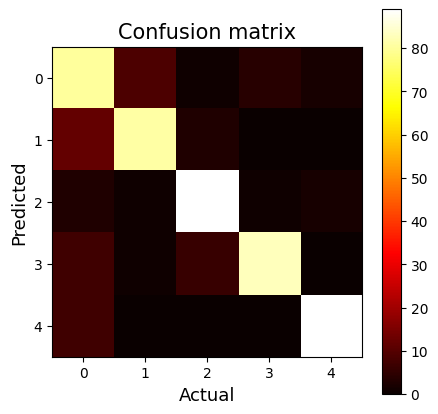

train mode | time: 17:56:39
loss: 0.995279148930595, accuracy: 0.9561011904761905, f1: 0.95446395043335, precision: 0.9583424137249876, recall: 0.9571328146180799


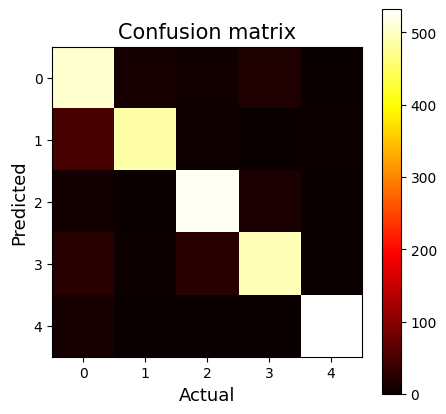

val mode | time: 17:56:42
loss: 1.1729444776262556, accuracy: 1.0026379870129871, f1: 1.0001319609322985, precision: 1.0027396122232477, recall: 1.0085630942353634


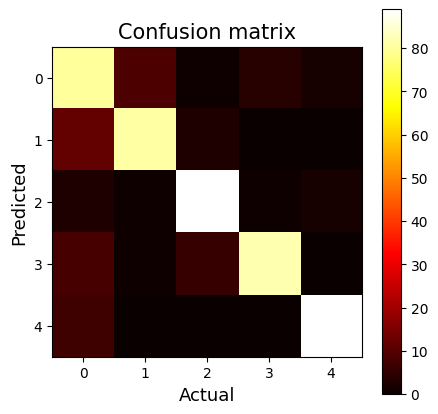

In [30]:
trainer = Trainer(df=new_df, net=model, lr=1e-3, batch_size=64, num_epochs=20)
trainer.run(net=model)

In [31]:
train_logs = []
val_logs = []

train_logs = trainer.train_df_logs
train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

logs = pd.concat([train_logs,val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss',
    'train_accuracy', 'val_accuracy',
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
                                 ]
logs.head()

,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall
0,1.339942,1.662699,0.608838,0.584483,0.556475,0.510931,0.614318,0.580736,0.686122,0.698973
1,1.151405,1.301673,0.798322,0.880682,0.788250,0.864237,0.801987,0.872474,0.805798,0.904529
2,1.118744,1.231641,0.831267,0.942911,0.823808,0.929661,0.835861,0.933313,0.836885,0.946965
3,1.090727,1.224847,0.859251,0.947511,0.853148,0.935135,0.862121,0.938495,0.864185,0.951056
4,1.079958,1.232214,0.866319,0.940679,0.859088,0.930740,0.867053,0.933019,0.870414,0.950415


In [32]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [33]:
#test_dataset = ECGDataset(df_mitbih_test)
test_dataset = ECGDataset(df_mitbih_test)
print(df_mitbih_test.shape)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, num_workers=0, shuffle=False)

(13732, 190)


In [34]:
#рассчитываем значение выхода нейронной сети по тестовым данным
y_pred, y_true = make_test_stage(test_dataloader, model)
y_pred.shape, y_true.shape

((13732,), (13732,))

In [35]:
id_to_label = {
    0: "Normal",     #0: "Нормальный"
    1: "Artial Premature", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Premature ventricular contraction", # "Преждевременное сокращение желудочков"
    3: "Fusion of ventricular and normal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Fusion of paced and normal" #"Cлияние стимулированного и нормального ритма"
}

id_to_label = {
    0: "Normal",     #0: "условно-здоровый"
    1: "Abnormal", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Abnormal", # "Преждевременное сокращение желудочков"
    3: "Abnormal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Abnormal" 
}

Text(0.5, 1.0, 'Ensemble Classification Report')

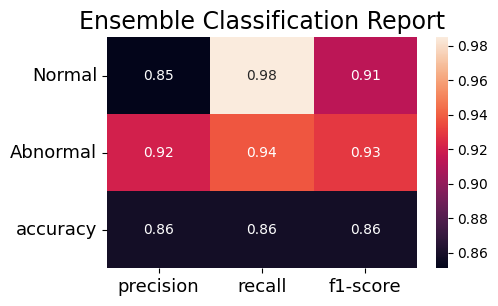

In [36]:
clf_report = classification_report(y_pred,
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),
                                   output_dict=True)


plt.figure(figsize=(5, 3))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-2].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=13, rotation=0)
plt.title("Ensemble Classification Report", fontsize=17)